# Obesity Rate Correlation Analysis

* The analysis will encompass data from the states of California, Ohio, and South Carolina.
* The objective is to find if there is correlation between obesity rate and the following measurements: 
    * Median household income
    * % With access to exercise opportunities
    * % of physically inactive
    * Primary care physicians rate
    * High School Unemployment rate
    * Unemployed rate
    

In [1]:
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import linregress
from pprint import pprint
from api_key import g_key 
import json
import gmaps


In [2]:
# Countyhealthrankings data for California, Ohio and South Carolina
# source https://www.countyhealthrankings.org/

csvpath_california = "./2020 County Health Rankings California Data - v1_0.csv"
csvpath_ohio = "./2020 County Health Rankings Ohio Data - v1_0.csv"
csvpath_south_carolina = "./2020 County Health Rankings South Carolina Data - v1_0.csv"

In [3]:
# Census URL to collect median household income for 2018 for every state and county

url = "https://api.census.gov/data/2018/acs/acs5?get=NAME,B19013_001E&for=county:*&in=state:*"
print(url)

https://api.census.gov/data/2018/acs/acs5?get=NAME,B19013_001E&for=county:*&in=state:*


## Data Cleaning
* Cleaning Data from the US Census and countyhealthrankings for the following states:
    * California 
    * Texas
    * Florida

In [4]:
# Converting census request into a DataFrame

census_data = requests.get(url).json()
df = pd.DataFrame(census_data).drop([0,])
df.head()

,0,1,2,3
1,"Washington County, Mississippi",30834,28,151
2,"Perry County, Mississippi",39007,28,111
3,"Choctaw County, Mississippi",37203,28,019
4,"Itawamba County, Mississippi",40510,28,057
5,"Carroll County, Mississippi",43060,28,015


In [5]:
# Renaming column headers from US Census data

new_df = df.rename(columns = {0:"County and State",
                             1:"Median Income",
                             2:"State Code",
                             3: "County Code"})
new_df.head()

,County and State,Median Income,State Code,County Code
1,"Washington County, Mississippi",30834,28,151
2,"Perry County, Mississippi",39007,28,111
3,"Choctaw County, Mississippi",37203,28,019
4,"Itawamba County, Mississippi",40510,28,057
5,"Carroll County, Mississippi",43060,28,015


In [6]:
# Combining State and County Code in order to merge the DataFrame with the Countyhealthrankings
# DataFrame

new_df["FIPS"] = new_df["State Code"].astype(str) + new_df["County Code"].astype(str)
new_df.head()

,County and State,Median Income,State Code,County Code,FIPS
1,"Washington County, Mississippi",30834,28,151,28151
2,"Perry County, Mississippi",39007,28,111,28111
3,"Choctaw County, Mississippi",37203,28,019,28019
4,"Itawamba County, Mississippi",40510,28,057,28057
5,"Carroll County, Mississippi",43060,28,015,28015


In [7]:
# Splitting the County and State column and creating two new columns for "County" and "State"
# to filter by California, Ohio and South Carolina

split_county_state = new_df["County and State"].str.split(",", n = 0, expand = True) 
new_df["County"]= split_county_state[0]
new_df["State"] = split_county_state[1]
new_df.head()

,County and State,Median Income,State Code,County Code,FIPS,County,State
1,"Washington County, Mississippi",30834,28,151,28151,Washington County,Mississippi
2,"Perry County, Mississippi",39007,28,111,28111,Perry County,Mississippi
3,"Choctaw County, Mississippi",37203,28,019,28019,Choctaw County,Mississippi
4,"Itawamba County, Mississippi",40510,28,057,28057,Itawamba County,Mississippi
5,"Carroll County, Mississippi",43060,28,015,28015,Carroll County,Mississippi


In [8]:
# Filtering data for the states of California, Ohio and South Carolina
# Selecting only needed columns for "County and State","Median Income","State and County Code", and "State"
selected_states = []
clean_data = new_df[["County and State","Median Income","FIPS","State","County"]].sort_values(by=['FIPS'])
states = [" California"," Ohio"," South Carolina"]
selected_states = clean_data.loc[(clean_data["State"]==" California") | (clean_data["State"]==" Ohio") | (clean_data["State"]==" South Carolina") ]
selected_states.head()

,County and State,Median Income,FIPS,State,County
1864,"Alameda County, California",92574,06001,California,Alameda County
1872,"Alpine County, California",64688,06003,California,Alpine County
1893,"Amador County, California",61198,06005,California,Amador County
1884,"Butte County, California",48443,06007,California,Butte County
1888,"Calaveras County, California",58151,06009,California,Calaveras County


In [9]:
# create a copy of the selected_states DataFrame in order to cast the FIPS and Median Income columns as integer

selected_states_copy = selected_states.copy()
selected_states_copy["FIPS"] = selected_states["FIPS"].astype(int)
selected_states_copy["Median Income"] = selected_states["Median Income"].astype(int)
selected_states_copy.dtypes

County and State    object
Median Income        int64
FIPS                 int64
State               object
County              object
dtype: object

In [10]:
# Read all csv files for California, Ohio and South Carolina.
# Extract only columns needed for analysis

california_df = pd.read_csv(csvpath_california)
ohio_df = pd.read_csv(csvpath_ohio)
south_carolina_df = pd.read_csv(csvpath_south_carolina)

ca_health_df = california_df[["FIPS","% Adults with Obesity","% Physically Inactive","% With Access to Exercise Opportunities","Primary Care Physicians Rate","High School Graduation Rate","% Unemployed"]]
ohio_health_df = ohio_df[["FIPS","% Adults with Obesity","% Physically Inactive","% With Access to Exercise Opportunities","Primary Care Physicians Rate","High School Graduation Rate","% Unemployed"]]
south_carolina_health_df = south_carolina_df[["FIPS","% Adults with Obesity","% Physically Inactive","% With Access to Exercise Opportunities","Primary Care Physicians Rate","High School Graduation Rate","% Unemployed"]]


In [11]:
# Concatenating all health data from countyhealth rankings for the three states into one DataFrame

all_states = [ca_health_df,ohio_health_df,south_carolina_health_df]
state_health_df = pd.concat(all_states)
state_health_df.head()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
0,6000,24,18,93,79,83.0,4.2
1,6001,19,15,100,110,87.0,3.0
2,6003,23,21,100,0,NaN,4.6
3,6005,30,25,76,67,88.0,4.0
4,6007,27,22,84,61,85.0,5.0


In [12]:
state_health_df.astype({'FIPS': 'str'}).dtypes

FIPS                                        object
% Adults with Obesity                        int64
% Physically Inactive                        int64
% With Access to Exercise Opportunities      int64
Primary Care Physicians Rate                 int64
High School Graduation Rate                float64
% Unemployed                               float64
dtype: object

In [13]:
# Add 0 to the front of State/County code
# Used apply function along with format. Apply passes a function and applies it to every value in the series. 
# {:0>5}'.format | padding and aligning strings. :0 refers to the character we want to use to pad, in this case 0. 
# > tells it to align to the right. The 5 is the length of the returned character/digit. 
# In this case since the FIPS is only 4 digits this will apply one 0 to the front, making it a total of 5 digits
# https://www.w3resource.com/python/python-format.php
# https://www.geeksforgeeks.org/python-pandas-apply/

format_FIPS = state_health_df['FIPS'].apply('{:0>5}'.format)

In [14]:
# Converting the formated FIPS to a DataFrame

FIPS_df = pd.DataFrame(format_FIPS)

In [15]:
# Replacing the formatted FIPS column to the DataFrame

state_health_df["FIPS"] = FIPS_df
state_health_df.head()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
0,06000,24,18,93,79,83.0,4.2
1,06001,19,15,100,110,87.0,3.0
2,06003,23,21,100,0,NaN,4.6
3,06005,30,25,76,67,88.0,4.0
4,06007,27,22,84,61,85.0,5.0


In [16]:
# state_health_df.dtypes
state_health_df_copy = state_health_df.copy()
state_health_df_copy["FIPS"] = state_health_df["FIPS"].astype(int)
state_health_df_copy.dtypes


FIPS                                         int64
% Adults with Obesity                        int64
% Physically Inactive                        int64
% With Access to Exercise Opportunities      int64
Primary Care Physicians Rate                 int64
High School Graduation Rate                float64
% Unemployed                               float64
dtype: object

In [17]:
# Merge data from the US census and countyhealthrankings into one DataFrame and drop NA

merged_df = pd.merge(state_health_df_copy,selected_states_copy,on="FIPS",how="left")
merged_df.dropna().describe()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,Median Income
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,30666.078534,32.811518,26.926702,69.240838,56.167539,87.528796,4.746597,54548.549738
std,16265.576067,5.757930,6.119414,20.396713,28.555269,7.983401,1.747623,15388.416031
min,6001.000000,17.000000,11.000000,5.000000,7.000000,36.000000,2.200000,24560.000000
25%,6098.000000,29.000000,23.000000,55.000000,36.500000,85.000000,3.600000,44986.000000
50%,39077.000000,33.000000,28.000000,71.000000,49.000000,88.000000,4.400000,51559.000000
75%,39172.000000,37.000000,31.000000,84.500000,72.500000,92.500000,5.500000,60629.500000
max,45091.000000,44.000000,41.000000,100.000000,154.000000,100.000000,18.100000,116178.000000


# Correlation and Regression Analysis

## State of Ohio

#### Obesity vs. % Physically Inactive

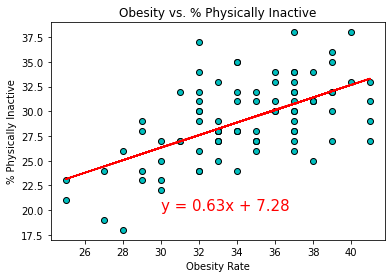

The r-squared value is: 0.5885488413368728


In [18]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_physical = ohio_analysis["% Physically Inactive"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_physical)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_physical,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Physically Inactive")
plt.title("Obesity vs. % Physically Inactive")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

#### Obesity vs. % With Access to Exercise Opportunities

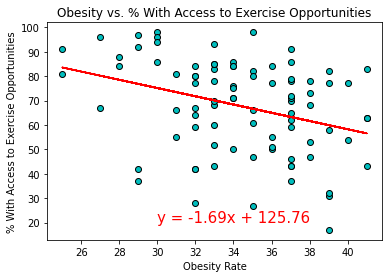

The r-squared value is: -0.3300541775387202


In [19]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_exercise = ohio_analysis["% With Access to Exercise Opportunities"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_exercise)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_exercise,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% With Access to Exercise Opportunities")
plt.title("Obesity vs. % With Access to Exercise Opportunities")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

#### Obesity vs. Primary Care Physicians Rate

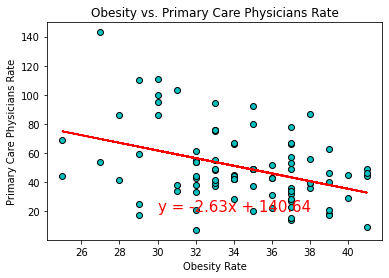

The r-squared value is: -0.38667593029688896


In [20]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_physician = ohio_analysis["Primary Care Physicians Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_physician)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_physician,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Primary Care Physicians Rate")
plt.title("Obesity vs. Primary Care Physicians Rate")
plt.show()

(print(f"The r-squared value is: {rvalue}"))


#### Obesity vs. High School Graduation Rate

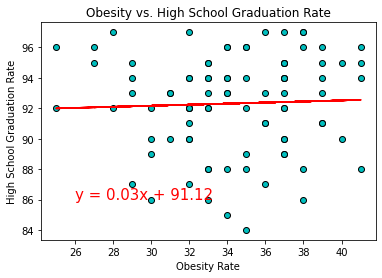

The r-squared value is: 0.04068527727508829


In [21]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_graduation = ohio_analysis["High School Graduation Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_graduation)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_graduation,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(26,86),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("High School Graduation Rate")
plt.title("Obesity vs. High School Graduation Rate")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

#### Obesity rate vs. % Unemployed

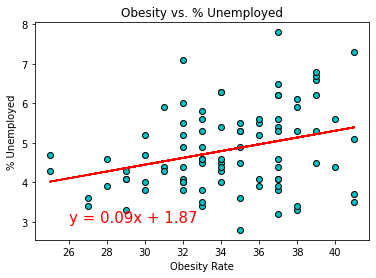

The r-squared value is: 0.3041473291712161


In [22]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_unemployed = ohio_analysis["% Unemployed"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_unemployed)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_unemployed,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(26,3),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Unemployed")
plt.title("Obesity vs. % Unemployed")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

In [23]:
ohio_analysis.dtypes

FIPS                                         int64
% Adults with Obesity                        int64
% Physically Inactive                        int64
% With Access to Exercise Opportunities      int64
Primary Care Physicians Rate                 int64
High School Graduation Rate                float64
% Unemployed                               float64
County and State                            object
Median Income                              float64
State                                       object
County                                      object
dtype: object

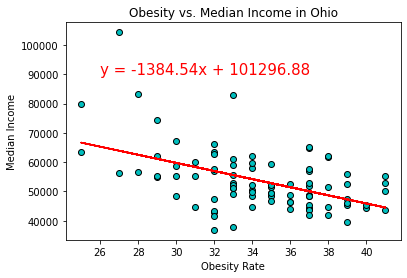

The r-squared value is: -0.48606554045367734


In [24]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_median_income = ohio_analysis["Median Income"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_median_income)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_median_income,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(26,90000),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Median Income")
plt.title("Obesity vs. Median Income in Ohio")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Heatmap for Obesity Rate

In [25]:
geocode = pd.read_csv("./Geocodes_USA_with_Counties.csv")

In [26]:
lat_lng = pd.DataFrame(geocode)

In [27]:
selected_counties = lat_lng.loc[(lat_lng["state"]=="OH") | (lat_lng["state"]=="CA") | (lat_lng["state"]=="SC")]
counties_df = selected_counties.iloc[:,[2,3,4,5,10]]

In [28]:
group_counties = counties_df.groupby("county").max().reset_index().dropna()
group_counties.head()

,county,state,latitude,longitude,estimated_population
0,Abbeville,SC,34.37,-82.34,10139
1,Adams,OH,38.94,-83.35,6569
2,Aiken,SC,33.84,-81.30,30359
3,Alameda,CA,37.90,-121.75,57184
4,Allen,OH,40.89,-83.88,18096


In [29]:
merged_df_copy = merged_df.copy()
selected_states_series = merged_df_copy["County"]
strip_county = selected_states_series.str.rstrip('County')
strip_space = strip_county.str.rstrip(' ')
strip_space

0               NaN
1           Alameda
2            Alpine
3            Amador
4             Butte
           ...     
190     Spartanburg
191          Sumter
192           Union
193    Williamsburg
194            York
Name: County, Length: 195, dtype: object

In [30]:
merged_df_copy["County"] = strip_space
merged_df_copy.dropna().head()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County
1,6001,19,15,100,110,87.0,3.0,"Alameda County, California",92574.0,California,Alameda
3,6005,30,25,76,67,88.0,4.0,"Amador County, California",61198.0,California,Amador
4,6007,27,22,84,61,85.0,5.0,"Butte County, California",48443.0,California,Butte
5,6009,31,31,60,44,90.0,4.0,"Calaveras County, California",58151.0,California,Calaveras
6,6011,41,28,75,32,89.0,12.9,"Colusa County, California",56704.0,California,Colusa


In [31]:
len(merged_df_copy)

195

In [32]:
group_counties_rename = group_counties.rename(columns = {"county":"County"})
group_counties_rename.head()

,County,state,latitude,longitude,estimated_population
0,Abbeville,SC,34.37,-82.34,10139
1,Adams,OH,38.94,-83.35,6569
2,Aiken,SC,33.84,-81.30,30359
3,Alameda,CA,37.90,-121.75,57184
4,Allen,OH,40.89,-83.88,18096


In [33]:
group_counties_rename_copy = group_counties_rename.copy()
group_counties_rename_copy["County"] = group_counties_rename["County"].astype(str)
# group_counties_rename_copy["Median Income"] = group_counties_rename["Median Income"].astype(int)
group_counties_rename_copy.dtypes

County                   object
state                    object
latitude                float64
longitude               float64
estimated_population      int64
dtype: object

In [34]:
merged_df_str = merged_df.copy()
merged_df_str["County"] = merged_df_str["County"].astype(str)
# group_counties_rename_copy["Median Income"] = group_counties_rename["Median Income"].astype(int)
merged_df_str.dtypes

FIPS                                         int64
% Adults with Obesity                        int64
% Physically Inactive                        int64
% With Access to Exercise Opportunities      int64
Primary Care Physicians Rate                 int64
High School Graduation Rate                float64
% Unemployed                               float64
County and State                            object
Median Income                              float64
State                                       object
County                                      object
dtype: object

In [35]:
geo_code_merge = pd.merge(merged_df_copy,group_counties_rename,on=["County"],how="left")
geo_code_clean = geo_code_merge.dropna()
geo_code_clean.head()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County,state,latitude,longitude,estimated_population
1,6001,19,15,100,110,87.0,3.0,"Alameda County, California",92574.0,California,Alameda,CA,37.90,-121.75,57184.0
3,6005,30,25,76,67,88.0,4.0,"Amador County, California",61198.0,California,Amador,CA,38.69,-120.05,6104.0
4,6007,27,22,84,61,85.0,5.0,"Butte County, California",48443.0,California,Butte,CA,39.98,-121.16,23889.0
5,6009,31,31,60,44,90.0,4.0,"Calaveras County, California",58151.0,California,Calaveras,CA,38.42,-120.20,10080.0
6,6011,41,28,75,32,89.0,12.9,"Colusa County, California",56704.0,California,Colusa,CA,39.31,-121.90,6178.0


In [36]:
figure = gmaps.figure()


locations = geo_code_clean[["latitude","longitude"]]
obesity_rate = geo_code_clean["% Adults with Obesity"]

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=obesity_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=.6)


# Add layer
figure.add_layer(heat_layer)

# Display figure
figure

Figure(layout=FigureLayout(height='420px'))

# All States

In [37]:
import glob
path = "./CountyHealthRankings"
# path_1 = "./CountyHealthRankings/2020 County Health Rankings Utah Data - v1_0.csv"
# read = pd.read_csv(path_1)
# read.head()
all_files = glob.glob(path + "/*.csv")

all_states = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_states.append(df)
frame = pd.concat(all_states, axis=0, ignore_index=True)
frame.head()
states_df = frame[["FIPS","% Adults with Obesity","% Physically Inactive","% With Access to Exercise Opportunities","Primary Care Physicians Rate","High School Graduation Rate","% Unemployed"]]
states_df.head()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
0,33000,28,21,88.0,91.0,89.0,2.5
1,33001,29,23,87.0,64.0,88.0,2.5
2,33003,27,22,81.0,92.0,94.0,2.5
3,33005,30,19,75.0,68.0,89.0,2.5
4,33007,34,26,74.0,114.0,92.0,3.2


In [38]:
states_df_copy = states_df.copy()
reformat_fips = states_df_copy['FIPS'].apply('{:0>5}'.format)
fips_df = pd.DataFrame(reformat_fips)
states_df_copy["FIPS"] = fips_df
states_df_copy.head()


,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
0,33000,28,21,88.0,91.0,89.0,2.5
1,33001,29,23,87.0,64.0,88.0,2.5
2,33003,27,22,81.0,92.0,94.0,2.5
3,33005,30,19,75.0,68.0,89.0,2.5
4,33007,34,26,74.0,114.0,92.0,3.2


In [62]:

all_states_merge = pd.merge(states_df_copy,clean_data,on="FIPS",how="left")
clean_all_states = all_states_merge.dropna()
clean_all_states.to_csv('./final_dataframe.csv', index=False)

In [63]:
len(clean_all_states["% Physically Inactive"])

2914

In [41]:
all_states_lat_lng = lat_lng.iloc[:,[2,3,4,5]]
rename_lat_lng = all_states_lat_lng.rename(columns = {"county":"County"})
rename_lat_lng.head()

,state,latitude,longitude,County
0,NY,40.81,-73.04,Suffolk
1,NY,40.81,-73.04,Suffolk
2,PR,18.16,-66.72,Adjuntas
3,PR,18.38,-67.18,NaN
4,PR,18.43,-67.15,Aguadilla


In [64]:
series = clean_all_states["County"]
strip_all = series.str.rstrip('County')
strips = strip_all.str.rstrip(' ')
strips

1          Belknap
2          Carroll
3         Cheshire
4             Coos
5          Grafton
           ...    
3188      Shoshone
3189         Teton
3190    Twin Falls
3191        Valley
3192    Washington
Name: County, Length: 2914, dtype: object

In [65]:
clean_all_states["County"] = strips

/Users/sherman/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
data_merge = pd.merge(all_states_merge,rename_lat_lng,on="County",how="left")


In [45]:
clean_dataset = data_merge.dropna()
drop_dups = clean_dataset.drop_duplicates(subset="County")
drop_dups

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County,state,latitude,longitude
850,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap,NH,43.33,-71.29
869,33003,27,22,81.0,92.0,94.0,2.5,"Carroll County, New Hampshire",61116,New Hampshire,Carroll,NH,43.83,-71.47
1007,33005,30,19,75.0,68.0,89.0,2.5,"Cheshire County, New Hampshire",63057,New Hampshire,Cheshire,NH,42.95,-72.29
1034,33007,34,26,74.0,114.0,92.0,3.2,"Coos County, New Hampshire",45696,New Hampshire,Coos,NH,44.48,-71.25
1057,33009,24,19,90.0,197.0,95.0,2.1,"Grafton County, New Hampshire",63153,New Hampshire,Grafton,NH,43.95,-71.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228987,16073,39,26,67.0,9.0,94.0,3.6,"Owyhee County, Idaho",40430,Idaho,Owyhee,ID,42.57,-115.85
228992,16075,35,30,67.0,43.0,87.0,3.6,"Payette County, Idaho",50289,Idaho,Payette,ID,43.96,-116.91
228995,16077,36,24,69.0,26.0,87.0,2.9,"Power County, Idaho",49985,Idaho,Power,ID,42.72,-112.99
228998,16079,35,22,93.0,48.0,94.0,5.7,"Shoshone County, Idaho",39091,Idaho,Shoshone,ID,47.17,-115.80


In [46]:
figure = gmaps.figure()


lat_lng = drop_dups[["latitude","longitude"]]
obesity = drop_dups["% Adults with Obesity"]

# Create heat layer
heat_layer = gmaps.heatmap_layer(lat_lng, weights=obesity, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=.8)


# Add layer
figure.add_layer(heat_layer)

# Display figure
figure

Figure(layout=FigureLayout(height='420px'))

## Obesity vs. % Physically Inactive

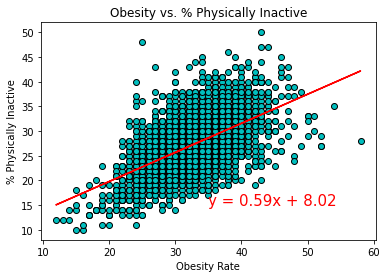

The r-squared value is: 0.5621279434298677


In [47]:
states_obesity_rate = all_states_merge["% Adults with Obesity"]
states_physical = all_states_merge["% Physically Inactive"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(states_obesity_rate, states_physical)
regress_values = states_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(states_obesity_rate,states_physical,color="c",edgecolors="black")
plt.plot(states_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(35,15),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Physically Inactive")
plt.title("Obesity vs. % Physically Inactive")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

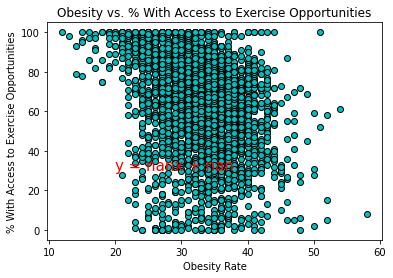

The r-squared value is: nan


In [53]:
states_obesity_rate = all_states_merge["% Adults with Obesity"]
states_exercise = all_states_merge["% With Access to Exercise Opportunities"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(states_obesity_rate, states_exercise)
regress_values = states_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(states_obesity_rate,states_exercise,color="c",edgecolors="black")
plt.plot(states_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(20,30),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% With Access to Exercise Opportunities")
plt.title("Obesity vs. % With Access to Exercise Opportunities")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

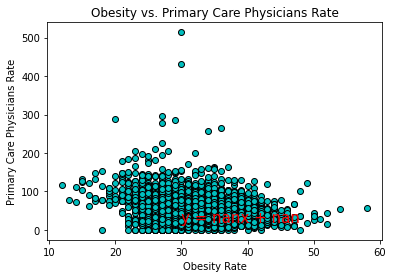

The r-squared value is: nan


In [54]:
states_obesity_rate = all_states_merge["% Adults with Obesity"]
states_physician = all_states_merge["Primary Care Physicians Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(states_obesity_rate, states_physician)
regress_values = states_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(states_obesity_rate,states_physician,color="c",edgecolors="black")
plt.plot(states_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Primary Care Physicians Rate")
plt.title("Obesity vs. Primary Care Physicians Rate")
plt.show()

(print(f"The r-squared value is: {rvalue}"))


1       68368
2       61116
3       63057
4       45696
5       63153
        ...  
3188    39091
3189    68818
3190    50778
3191    55299
3192    37206
Name: Median Income, Length: 3141, dtype: object

In [55]:
states_obesity_rate = all_states_merge["% Adults with Obesity"]
median_income = all_states_merge["Median Income"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(states_obesity_rate, median_income)
regress_values = states_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(states_obesity_rate,median_income,color="c",edgecolors="black")
plt.plot(states_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(26,90000),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Median Income")
plt.title("Obesity vs. Median Income in Ohio")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

TypeError: unsupported operand type(s) for +: 'float' and 'str'